# Precipitation tuning pt. 2: profiling thresholds

In this section, we will perform a full analysis on the precipitation adjustment to determine what thresholds we ought to use to adjust the data.

We will use the following criteria to determine this:
* RMSE of differences of DOY statistics between reference and adjusted:
    * Minimum
    * Mean
    * Maximum
* RMSE of differences of mean indicators:
    * dry spell total length
    * wet spell total length
    * maximum consecutive dry days
    * maximum consecutive wet days



In [1]:
import xarray as xr
from xclim import sdba
from dask.distributed import Client
from xclim import indices
from xclim.sdba.detrending import LoessDetrend
import dask
from dask_jobqueue import SLURMCluster
from baeda import *

# we have to make some big chunks and this will silence a warning about that
dask.config.set(**{"array.slicing.split_large_chunks": False})

# client = Client()

# for interactive nb testing
cluster = SLURMCluster(
    cores=24,
    memory="128GB",
    # queue="debug",
    queue="t2small",
    # walltime="01:00:00",
    walltime="12:00:00",
    log_directory=".",
    account="cmip6",
    interface="ib0",
)
client = Client(cluster)
cluster.scale(1)


ref_var_id = "tp"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = get_era5_fps(ref_var_id, ref_start_year, ref_end_year)


hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
ref_ds = (
    xr.open_mfdataset(ref_fps)
    .convert_calendar("noleap")
    .sel(expver=1)
    .drop_vars("expver")
)

ref = get_rechunked_da(ref_ds, ref_var_id)
hist = get_rechunked_da(hist_ds, var_id)

ref.attrs["units"] = "m d-1"
ref = sdba.processing.jitter_under_thresh(ref, thresh="0.01 mm d-1")
hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

dqm = sdba.DetrendedQuantileMapping.train(
    ref=ref,
    hist=hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")

scen = dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
scen = scen.compute()

/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [64]:
doy_func_lu = {"min": np.min, "max": np.max, "mean": np.mean}
indices_lu = {
    "mcdd": indices.maximum_consecutive_dry_days,
    "dstl": indices.dry_spell_total_length,
    "mcwd": indices.maximum_consecutive_wet_days,
    "wstl": indices.wet_spell_total_length,
}


def summarize(da):
    """Function for summarizing and packaging results for a given model over DOY and indices."""
    results = {}

    results["doy"] = {}
    for func in doy_func_lu:
        results["doy"][func] = doy_stats(da, doy_func_lu[func])

    results["indices"] = {}
    for func in indices_lu:
        results["indices"][func] = indices_lu[func](da).rename(func)

    return results

In [46]:
results = {}
results["ref"] = summarize(ref)

In [47]:
results["MIROC6"] = summarize(scen)

In [9]:
rmse(results["MIROC6"]["doy"]["mean"], results["ref"]["doy"]["mean"])

<xarray.DataArray ()>
array(0.00110098)
Coordinates:
    height       float64 2.0
    spatial_ref  int64 0

What are the different thresholds we want to test?
* jitter-under threshold (in mm / d): we have seen that 0.1 seems to give better results than 0.01, and that 0.2 gave even better results, for the MIROC6 model. So let's test values spanning from 0.005 to 0.5. 
* frequency adaptation threshold (in mm / d): We will test values from 0.05 to 2. 

In [ ]:
hist_fps, sim_ref_fps = get_all_hist_fps("MIROC6", "pr")

In [ ]:
for ju_thresh in [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]:
    for adapt_freq_thresh in [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2]:

        scen = run_adjust(ref, hist, det, ju_thresh, adapt_freq_thresh)

        results = {}
        results["ref"] = summarize(ref)

        results["MIROC6"] = summarize(scen)

        print(
            ju_thresh,
            adapt_freq_thresh,
            rmse(results["MIROC6"]["doy"]["mean"], results["ref"]["doy"]["mean"]),
        )

In [ ]:
# # calculate the mean warm Spell Length Distribution
# sim_prop = sdba.properties.spell_length_distribution(
#     da=sim, thresh="28 degC", op=">", stat="mean", group="time"
# )


# scen_prop = sdba.properties.spell_length_distribution(
#     da=scen, thresh="28 degC", op=">", stat="mean", group="time"
# )

# ref_prop = sdba.properties.spell_length_distribution(
#     da=ref_future, thresh="28 degC", op=">", stat="mean", group="time"
# )
# # measure the difference between the prediction and the reference with an absolute bias of the properties
# measure_sim = sdba.measures.bias(sim_prop, ref_prop)
# measure_scen = sdba.measures.bias(scen_prop, ref_prop)

# plt.figure(figsize=(5, 3))
# plt.plot(measure_sim.location, measure_sim.values, ".", label="biased model (sim)")
# plt.plot(measure_scen.location, measure_scen.values, ".", label="adjusted model (scen)")
# plt.title(
#     "Bias of the mean of the warm spell \n length distribution compared to observations"
# )

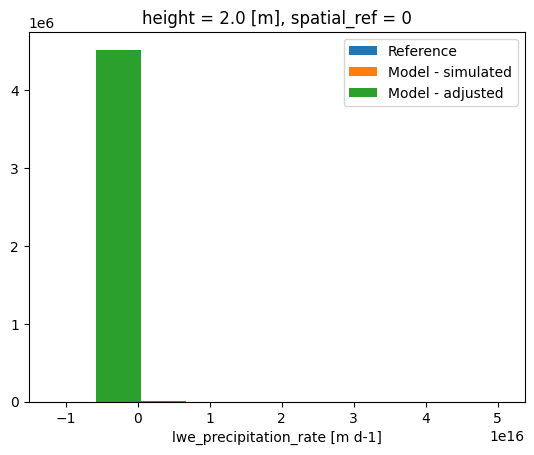

In [41]:
# convert model data to meters / day to match ref and scen
hist_mpd = units.convert_units_to(hist, "m d-1")

plot_avg_ts(ref, hist_mpd, scen)